------
### Library setup and getting prepared the dataset 


In [1]:
#!pip install git+https://github.com/huggingface/nlp
!pip install --quiet transformers
!pip install --quiet nlp==0.2.0 
!pip install --quiet datasets

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import transformers
import nlp
# from torch.utils.data import Dataset
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.CRITICAL)

import json
from tqdm.notebook import tqdm

tqdm.pandas()

------
### Fetching our data


In [3]:
# paths to semeval dataset
path_to_train = "DataForBertFinetuning/Classification/train2.csv"
path_to_test = "DataForBertFinetuning/Classification/test2.csv"
path_to_validation = "DataForBertFinetuning/Classification/dev2.csv"

path_to_pan_train = "DataForBertFinetuning/Rumed/rutrain1.csv"
path_to_pan_validation = "DataForBertFinetuning/Rumed/rudev1.csv"
path_to_pan_test = "DataForBertFinetuning/Rumed/rutest1.csv"

In [4]:
print(path_to_train)

DataForBertFinetuning/Classification/train2.csv


In [5]:
!pip install datasets

In [6]:
from datasets import load_dataset

In [7]:
dataset_dict = {
  "clas": load_dataset('csv', data_files={
      'train': path_to_train,
      'validation': path_to_validation,
      'test': path_to_test,
  }),
  "rumed": load_dataset('csv', data_files={
      'train': path_to_pan_train,
      'validation': path_to_pan_validation,
      'test': path_to_pan_test,
  })
}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
dataset_dict

{'clas': DatasetDict({
     train: Dataset({
         features: ['id', 'text', 'label_1', 'label'],
         num_rows: 95357
     })
     validation: Dataset({
         features: ['id', 'text', 'label_1', 'label'],
         num_rows: 11329
     })
     test: Dataset({
         features: ['id', 'text', 'label_1', 'label'],
         num_rows: 2372
     })
 }),
 'rumed': DatasetDict({
     train: Dataset({
         features: ['sentence1', 'sentence2', 'sent_1', 'sent', 'id'],
         num_rows: 12531
     })
     validation: Dataset({
         features: ['sentence1', 'sentence2', 'sent_1', 'sent', 'id'],
         num_rows: 1407
     })
     test: Dataset({
         features: ['sentence1', 'sentence2', 'sent_1', 'sent', 'id'],
         num_rows: 1936
     })
 })}

We can show one example from each task.

In [9]:
for task_name, dataset in dataset_dict.items():
    print(task_name)
    print(dataset_dict[task_name]["train"][0])
    print()

clas
{'id': 583317, 'text': 'Forbes в\xa022-й раз признал Билла Гейтса самым богатым американцем', 'label_1': 'Общество', 'label': 0}

rumed
{'sentence1': 'Анализы отличались содержанием креатина 17 (исходный уровень 05 по старым записям) и лактата 24.', 'sentence2': 'У пациента повышенный уровень азота в моче', 'sent_1': 'neutral', 'sent': 0, 'id': '23eb9986-66c7-11e7-9ef9-f45c89b91419'}



<Figure size 432x288 with 0 Axes>

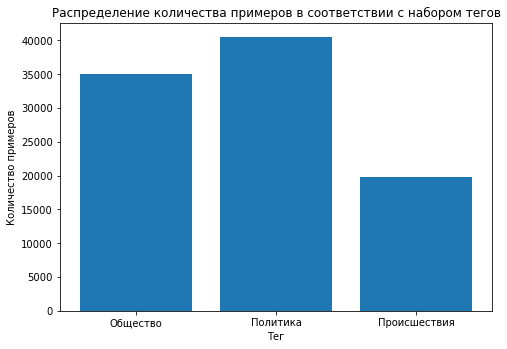

In [10]:
l=dataset_dict['clas']['train']['label']
fig=plt.figure()
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
text = ['Общество', 'Политика', 'Происшествия']
tag = [len([x for x in l if int(x)==0]),len([x for x in l if int(x)==1]),len([x for x in l if int(x)==2])]
ax.bar(text,tag)
plt.xlabel("Тег")
plt.ylabel("Количество примеров")
plt.title("Распределение количества примеров в соответствии с набором тегов")
plt.show()

------
### Creating multitask training model

In [11]:
class MultitaskModel(transformers.PreTrainedModel): #Настройка многозадачной модели в качестве предварительно обученной модели
    def __init__(self, encoder, taskmodels_dict):
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict):
        #Создаем каждую из двух моделей с одной задачей и предоставляя им общий доступ к одному конфигу.
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name, 
                config=model_config_dict[task_name],
            )
            if shared_encoder is None:
                print(cls.get_encoder_attr_name(model))
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model
        return cls(encoder=shared_encoder, taskmodels_dict=taskmodels_dict)

    @classmethod
    def get_encoder_attr_name(cls, model):#Проверяем архитектуру модели
        model_class_name = model.__class__.__name__
        if model_class_name.startswith("Bert"):
            return "bert"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    def forward(self, task_name, **kwargs):
        return self.taskmodels_dict[task_name](**kwargs)

Берем далее нашу ранее обученную модель

In [12]:
backbone_id = "Out_Bert_Pretrained/checkpoint-2500"

model_name=backbone_id
multitask_model=MultitaskModel.create(model_name=model_name, 
         model_type_dict={
                 "clas" : transformers.AutoModelForSequenceClassification,
                 "rumed": transformers.AutoModelForSequenceClassification,
         },
         model_config_dict={
                 "clas" : transformers.AutoConfig.from_pretrained(model_name,num_labels=1),
                 "rumed": transformers.AutoConfig.from_pretrained(model_name, num_labels=1),
             
         }                                   
            )

Some weights of the model checkpoint at Out_Bert_Pretrained/checkpoint-2500 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Out_Bert_

bert


Some weights of the model checkpoint at Out_Bert_Pretrained/checkpoint-2500 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Out_Bert_

Чтобы подтвердить, что все три модели задач используют один и тот же кодер, проверяем указатели данных соответствующих кодеров. В этом случае проверяем, что все вложения word в каждой модели указывают на одну и ту же ячейку памяти.

In [13]:
if model_name.startswith('Out_Bert_Pretrained/checkpoint-2500'):
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict['clas'].bert.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["rumed"].bert.embeddings.word_embeddings.weight.data_ptr())
else:
    print("Ckeck the model name")

139747054927936
139747054927936
139747054927936


In [14]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

------
### Preparation of dataset:

In [15]:
max_length=128

def convert_to_pan_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=512, padding="max_length"
    )
    features["labels"] = example_batch["sent"]
    return features

def convert_to_semeval_features(example_batch):
    features = tokenizer.batch_encode_plus(
        example_batch["text"], max_length=max_length, padding="max_length"
    )
    features["labels"] = example_batch["label"]
    return features

#Construct the featurized input data
featurized_funct_dict={
                 "clas" : convert_to_semeval_features,
                 "rumed": convert_to_pan_features
}

Теперь, определив вышеуказанные функции, используем метод `dataset.map`, которая обрабатывает сопоставление и кэширует функции.

In [16]:
column_dict={
                 "clas"          : ['input_ids', 'attention_mask','labels'],
             "rumed": ['input_ids', 'attention_mask', 'labels'],
}
#Featurizing datasets
features_dict={}
for  task, dataset in dataset_dict.items():
    print("--------------task---------:",task)
    features_dict[task]={}
    for phase, phase_dataset in dataset.items():
       
        features_dict[task][phase]=phase_dataset.map(featurized_funct_dict[task],
                                                     batched=True, 
                                                     load_from_cache_file=False)
        print(task, phase, len(phase_dataset), len(features_dict[task][phase]))
        features_dict[task][phase].set_format(
            type='torch',
            columns=column_dict[task]
        )
        print(task, phase, len(phase_dataset), len(features_dict[task][phase]))

--------------task---------: clas


  0%|          | 0/96 [00:00<?, ?ba/s]

clas train 95357 95357
clas train 95357 95357


  0%|          | 0/12 [00:00<?, ?ba/s]

clas validation 11329 11329
clas validation 11329 11329


  0%|          | 0/3 [00:00<?, ?ba/s]

clas test 2372 2372
clas test 2372 2372
--------------task---------: rumed


  0%|          | 0/13 [00:00<?, ?ba/s]

rumed train 12531 12531
rumed train 12531 12531


  0%|          | 0/2 [00:00<?, ?ba/s]

rumed validation 1407 1407
rumed validation 1407 1407


  0%|          | 0/2 [00:00<?, ?ba/s]

rumed test 1936 1936
rumed test 1936 1936


## Preparing a multi-task data loader and Trainer

Определяем "MultitaskDataloader", который объединяет несколько загрузчиков данных в один "загрузчик данных" и выполняет выборку из разных однозадачных загрузчиков данных и выдавать пакет задач и соответствующее имя задачи (+ добавляем `task_name` к пакетным данным).
Также переопределяем метод `get_train_dataloader` в `Trainer`, чтобы оно могло работать с `MultitaskDataloader`. 

In [17]:
import dataclasses
from torch.utils.data.dataloader import DataLoader
from transformers.data.data_collator import DataCollator, InputDataClass, DefaultDataCollator
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict


class NLPDataCollator(DefaultDataCollator):
#Расширение существующего DataCollator для работы с пакетами наборов данных NLP
    def collate_batch(self, features: List[Union[InputDataClass, Dict]]) -> Dict[str, torch.Tensor]:
        first = features[0]
        if isinstance(first, dict):
          # NLP data sets current works presents features as lists of dictionary
          # (one per example), so we  will adapt the collate_batch logic for that
          if "labels" in first and first["labels"] is not None:
              if first["labels"].dtype == torch.int64:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              else:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              batch = {"labels": labels}
          for k, v in first.items():
              if k != "labels" and v is not None and not isinstance(v, str):
                  batch[k] = torch.stack([f[k] for f in features])
          return batch
        else:
          # otherwise, revert to using the default collate_batch
          return DefaultDataCollator().collate_batch(features)


class StrIgnoreDevice(str):
    def to(self, device):
        return self


class DataLoaderWithTaskname:
    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


class MultitaskDataloader:
    def __init__(self, dataloader_dict):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset) 
            for dataloader in self.dataloader_dict.values()
        )

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):
#Для каждого пакета выполняем выборку задачи и извлекаем пакет из соответствующего
#загрузчика данных задачи. Используем выборку, пропорциональную размеру
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])    

class MultitaskTrainer(transformers.Trainer):

    def get_single_train_dataloader(self, task_name, train_dataset):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        else:
            train_sampler = (
                RandomSampler(train_dataset)
                if self.args.local_rank == -1
                else DistributedSampler(train_dataset)
            )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              train_dataset,
              batch_size=self.args.train_batch_size,
              sampler=train_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )
        return data_loader

    def get_train_dataloader(self):
#Возвращает многозадачный загрузчик данных, который на самом деле не является загрузчиком данных
#но итеративный, который возвращает генератор, который выполняет выборку из каждого
#загрузчика данных задачи
        return MultitaskDataloader({
            task_name: self.get_single_train_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.train_dataset.items()
        })


## Train

In [ ]:
train_dataset = {
    task_name: dataset["train"] 
    for task_name, dataset in features_dict.items()
}
trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="Out_Bert_Finetuned",
        overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=1,
        # Adjust batch size if this doesn't fit on the Colab GPU
        per_device_train_batch_size=4,  
        save_steps=3000,
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
) 
trainer.train()

/srv/conda/envs/saturn/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 107888
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 26973
  Number of trainable parameters = 109483778
2023-02-19 23:20:39.310226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 23:20:39.5

Step,Training Loss
500,0.561100
1000,0.536300
1500,0.496300
2000,0.473100
2500,0.495400
3000,0.460900
3500,0.475800


Saving model checkpoint to Out_Bert_Finetuned/checkpoint-3000
Configuration saved in Out_Bert_Finetuned/checkpoint-3000/config.json
Model weights saved in Out_Bert_Finetuned/checkpoint-3000/pytorch_model.bin
